# Imports

In [1]:
import os
import sys
import re
import numpy as np
import pandas as pd
import json

In [2]:
from datetime import datetime, timedelta
import hashlib

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [5]:
import ReduceDim
import ClusterData
import OneClass
import DetectAnomaly

2024-10-01 09:19:49.174674: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 09:19:49.226983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 09:19:50.025321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
import EncodeCommand
import DeepLearningAnomalyDetection2
import TimeDependentDeepLearningAnomalyDetection

In [7]:
from normal_utilities import *
from silent_utilities import *
from silent_utilities_2 import *
from preprocess_utilities import *

# Creation of datasets

## Normal execution

In [ ]:
fp = '../../../../../temp_logs/20240418/login01.laurel.log'
df = read(fp)
df_expanded = df['message'].apply(parse_audit_log).apply(pd.Series)
df = pd.concat([df, df_expanded], axis=1)
df.head()
df = preprocess_laurel(df)
save(df, fp + '.csv')

In [ ]:
normal_dataset_fp = fp + '.csv'
new_path = '../cleaned_data/normal.csv'
save(df, new_path)

## LinPeas noisy execution on laurel

In [ ]:
# First type of log file:
# laurel_anomalous_new
fp = '../data/laurel_anomalous_new/audit.log'
fps = [fp]
fps += [fp + f'.{str(i)}' for i in range(1,8)]
print(fps)

In [ ]:
for fp in fps:
    df = read(fp)
    df = preprocess_laurel(df)
    save(df, fp + '.csv')

## LinPeas silent execution on laurel

In [ ]:
# First type of log file:
# laurel_anomalous_new
fp = '../data/silent/audit.log'
fps = [fp]
fps += [fp + f'.{str(i)}' for i in range(1,11)]
print(fps)

In [ ]:
for fp in fps:
    df = read(fp)
    df = preprocess_laurel(df)
    save(df, fp + '.csv')

In [ ]:
import os

def concatenate_files(input_files, output_file):
    with open(output_file, 'w') as outfile:
        for filename in input_files:
            with open(filename, 'r') as infile:
                # Read each input file and write its content to the output file
                outfile.write(infile.read())
                outfile.write("\n")  # Optional: Adds a newline between files

# List of 10 input files (full paths or filenames)
input_files = ['../data/silent/audit.log', '../data/silent/audit.log.1', '../data/silent/audit.log.2', '../data/silent/audit.log.3', '../data/silent/audit.log.4', '../data/silent/audit.log.5', '../data/silent/audit.log.6', '../data/silent/audit.log.7', '../data/silent/audit.log.8', '../data/silent/audit.log.9', '../data/silent/audit.log.10']
input_files = input_files[::-1]
# Output file where the concatenated content will be written
output_file = 'silent.log'

# Call the function to concatenate the files
concatenate_files(input_files, output_file)

print(f"All files have been concatenated into {output_file}")

In [ ]:
# merge the csv files
fp = '../data/silent.log'
df = read(fp)
df = preprocess_laurel(df)
save(df, fp + '.csv')

# Preprocessing

## Data Reading

In [8]:
normal = pd.read_csv('../cleaned_data/normal.csv')
anomalous = pd.read_csv('../cleaned_data/anomalous0.csv')
silent = pd.read_csv('../cleaned_data/silent.log.csv')

In [9]:
encoder = EncodeCommand.EncodeCommand()
normal_ = preprocess(normal,encoder)
anomalous_ = preprocess(anomalous, encoder)
silent_ = preprocess(silent, encoder)

In [10]:
normal_.shape, anomalous_.shape, silent_.shape

((100000, 9), (1000, 9), (31006, 9))

In [11]:
normal_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.781250,0.230469,0.000,0.0,0.0,0.0,1.0
1,0.0,3.0,0.636719,0.417969,1.862,0.0,8.0,0.0,2.0
2,0.0,0.0,0.539062,0.539062,0.002,0.0,0.0,0.0,3.0
3,0.0,0.0,0.539062,0.539062,0.006,0.0,0.0,0.0,3.0
4,0.0,0.0,0.539062,0.539062,0.001,0.0,0.0,0.0,3.0


In [12]:
anomalous_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0
1,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0
2,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0
3,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0
4,-2.0,1.0,0.644531,0.890625,0.0,0.0,0.0,0.0,54.0


In [13]:
silent_.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.449219,0.164062,0.000,0.0,0.0,0.0,1.0
1,0.0,2.0,0.449219,0.281250,0.007,0.0,0.0,0.0,1.0
2,0.0,2.0,0.449219,0.089844,0.019,0.0,0.0,0.0,1.0
3,0.0,2.0,0.449219,0.210938,-0.025,0.0,0.0,0.0,1.0
4,0.0,2.0,0.449219,0.335938,0.052,0.0,0.0,0.0,1.0


In [14]:
def merge_n_rows(df: pd.DataFrame, n: int = 3) -> pd.DataFrame:
    # Calculate how many rows need to be added to make the number of rows divisible by n
    num_rows_to_add = (n - len(df) % n) % n
    
    # Append rows of NaNs at the end if necessary, before reshaping
    if num_rows_to_add > 0:
        nan_rows = pd.DataFrame(0, index=range(num_rows_to_add), columns=df.columns)
        df = pd.concat([df, nan_rows], ignore_index=True)

    # Reshape the dataframe by merging every n rows into one
    merged_data = df.values.reshape(-1, df.shape[1] * n)

    # Create new column names for the merged dataframe
    new_columns = []
    for i in range(n):
        for col in df.columns:
            new_columns.append(f'{col}_part_{i+1}')

    # Return a new dataframe with the merged data
    merged_df = pd.DataFrame(merged_data, columns=new_columns)
    
    return merged_df


In [15]:
merged_normal = merge_n_rows(normal_, 3)
merged_anomalous = merge_n_rows(anomalous_, 3)
merged_silent = merge_n_rows(silent_, 3)

In [16]:
merged_normal.head()

,exit_part_1,items_part_1,ppid_part_1,pid_part_1,timedelta_part_1,id_anomalies_part_1,num_id_anomalies_part_1,fp_length_part_1,enc_comm_part_1,exit_part_2,...,enc_comm_part_2,exit_part_3,items_part_3,ppid_part_3,pid_part_3,timedelta_part_3,id_anomalies_part_3,num_id_anomalies_part_3,fp_length_part_3,enc_comm_part_3
0,0.0,2.0,0.781250,0.230469,0.000,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,0.0,0.539062,0.539062,0.002,0.0,0.0,0.0,3.0
1,0.0,0.0,0.539062,0.539062,0.006,0.0,0.0,0.0,3.0,0.0,...,3.0,0.0,0.0,0.539062,0.539062,0.001,0.0,0.0,0.0,3.0
2,0.0,2.0,0.417969,0.363281,0.002,0.0,8.0,0.0,4.0,0.0,...,4.0,0.0,0.0,0.539062,0.539062,0.001,0.0,0.0,0.0,3.0
3,0.0,0.0,0.539062,0.539062,0.001,0.0,0.0,0.0,3.0,0.0,...,5.0,0.0,0.0,0.539062,0.539062,0.001,0.0,0.0,0.0,3.0
4,0.0,3.0,0.636719,0.519531,2.031,0.0,8.0,0.0,2.0,0.0,...,3.0,0.0,0.0,0.539062,0.539062,0.006,0.0,0.0,0.0,3.0


# Experiments and Results

## Statistics and ML

### Clustering

#### Spell

#### Spell (Modified Edit Distance)

### Dimensionality Reduction

#### PCA, t-SNE, uMAP on single observations

In [28]:
# random sample of original dataset, done for feasibility
normal_reduced = normal_.sample(1000, random_state=42).reset_index(drop=True)
anomalous_reduced = anomalous_.sample(100, random_state=42).reset_index(drop=True)
silent_reduced = silent_.sample(100, random_state=42).reset_index(drop=True)

In [29]:
normal_reduced.head()

,exit,items,ppid,pid,timedelta,id_anomalies,num_id_anomalies,fp_length,enc_comm
0,0.0,2.0,0.085938,0.796875,0.001,0.0,0.0,0.0,52.0
1,0.0,2.0,0.085938,0.843750,0.004,0.0,0.0,0.0,69.0
2,0.0,2.0,0.152344,0.457031,0.001,0.0,0.0,0.0,52.0
3,0.0,2.0,0.085938,0.847656,0.001,0.0,0.0,0.0,52.0
4,0.0,2.0,0.218750,0.722656,0.001,0.0,8.0,0.0,5.0


In [30]:
r = ReduceDim.ReduceDim(3, normal_reduced, [0, 0])

pca_reduced_data = r.pca()
tsne_reduced_data = r.tsne()
umap_reduced_data = r.umap()

# reduce with previous umap the anomalous data points
umap_anomalous = r.test_umap(anomalous_reduced)
umap_silent = r.test_umap(silent_reduced)

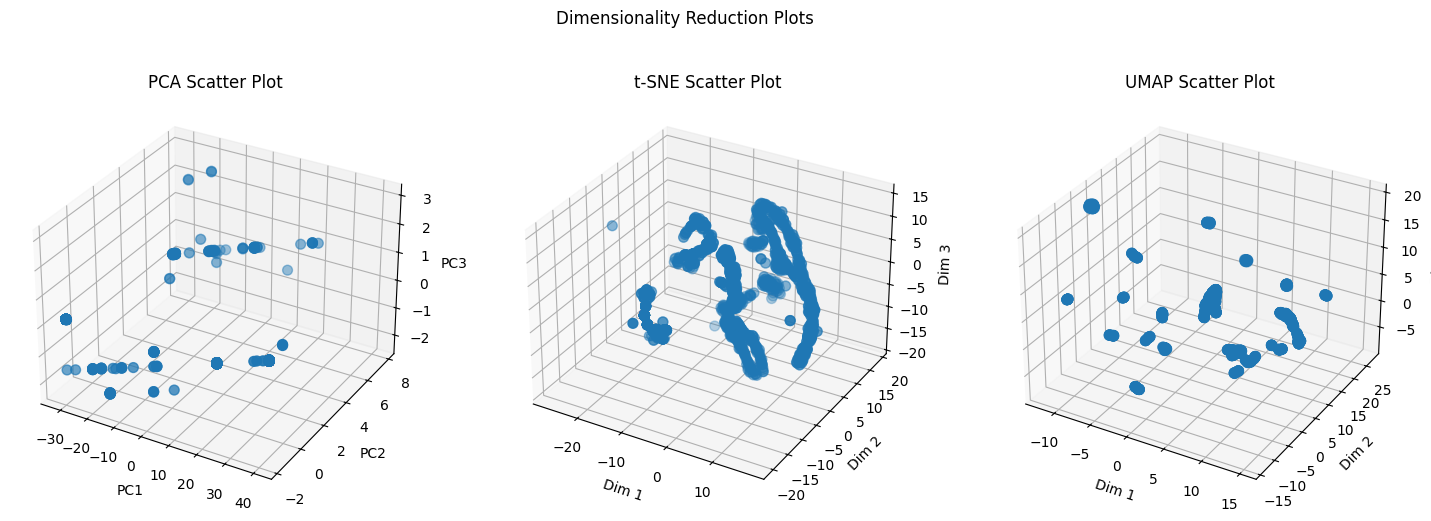

In [31]:
fig = plt.figure(figsize=(18, 6))
i = 0
# Plot PCA
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(pca_reduced_data[:, 0], pca_reduced_data[:, 1], pca_reduced_data[:, 2], s=50)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title(f'PCA Scatter Plot')

# Plot t-SNE
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(tsne_reduced_data[:, 0], tsne_reduced_data[:, 1], tsne_reduced_data[:, 2], s=50)
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
ax2.set_title(f't-SNE Scatter Plot')

# Plot UMAP
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(umap_reduced_data[:, 0], umap_reduced_data[:, 1], umap_reduced_data[:, 2], s=50)
ax3.set_xlabel('Dim 1')
ax3.set_ylabel('Dim 2')
ax3.set_zlabel('Dim 3')
ax3.set_title(f'UMAP Scatter Plot')

plt.suptitle(f'Dimensionality Reduction Plots')
plt.show()

#### PCA, tSNE, uMAP on sequences of 3 observations

In [32]:
# random sample of original dataset, done for feasibility
merged_normal_reduced = merged_normal.sample(1000, random_state=42).reset_index(drop=True)
merged_anomalous_reduced = merged_anomalous.sample(100, random_state=42).reset_index(drop=True)
merged_silent_reduced = merged_silent.sample(100, random_state=42).reset_index(drop=True)

In [33]:
r = ReduceDim.ReduceDim(3, merged_normal_reduced, [0, 0])

merged_pca_reduced_data = r.pca()
merged_tsne_reduced_data = r.tsne()
merged_umap_reduced_data = r.umap()

# reduce with previous umap the anomalous data points
merged_umap_anomalous = r.test_umap(merged_anomalous_reduced)
merged_umap_silent = r.test_umap(merged_silent_reduced)

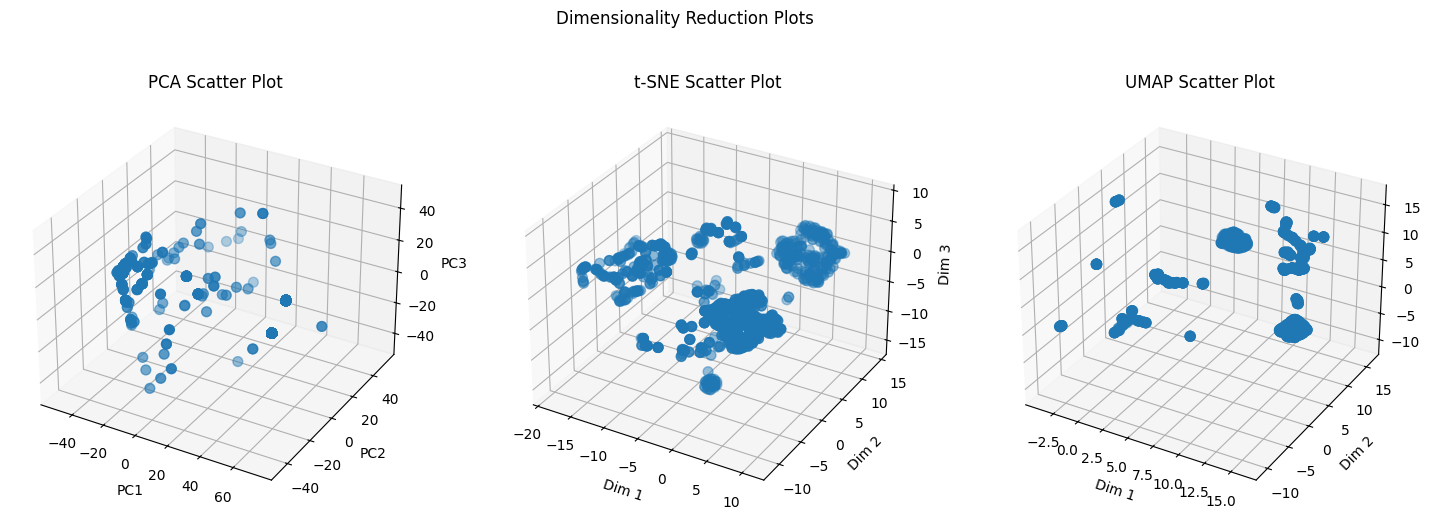

In [34]:
fig = plt.figure(figsize=(18, 6))
i = 0
# Plot PCA
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(merged_pca_reduced_data[:, 0], merged_pca_reduced_data[:, 1], merged_pca_reduced_data[:, 2], s=50)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title(f'PCA Scatter Plot')

# Plot t-SNE
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(merged_tsne_reduced_data[:, 0], merged_tsne_reduced_data[:, 1], merged_tsne_reduced_data[:, 2], s=50)
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
ax2.set_title(f't-SNE Scatter Plot')

# Plot UMAP
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(merged_umap_reduced_data[:, 0], merged_umap_reduced_data[:, 1], merged_umap_reduced_data[:, 2], s=50)
ax3.set_xlabel('Dim 1')
ax3.set_ylabel('Dim 2')
ax3.set_zlabel('Dim 3')
ax3.set_title(f'UMAP Scatter Plot')

plt.suptitle(f'Dimensionality Reduction Plots')
plt.show()

### Anomaly Detection

#### Isolation Forest on single observations (normal vs anomalous)

In [35]:
# creation of artificial anomaly data point
labels = np.concatenate([np.ones(umap_anomalous.shape[0]), np.zeros(umap_reduced_data.shape[0])])
new_data = np.vstack((umap_anomalous, umap_reduced_data))

labels_silent = np.concatenate([np.ones(umap_silent.shape[0]), np.zeros(umap_reduced_data.shape[0])])
new_data_silent = np.vstack((umap_silent, umap_reduced_data))

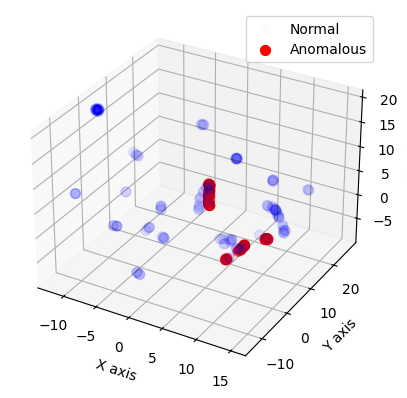

In [42]:
# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data[labels == 0][:, 0], new_data[labels == 0][:, 1], new_data[labels == 0][:, 2], 
           color='b', label='Normal', s=50, alpha=0.01)  # Blue for normal points

ax.scatter(new_data[labels == 1][:, 0], new_data[labels == 1][:, 1], new_data[labels == 1][:, 2], 
           color='r', label='Anomalous', s=50)  # Red for anomalies

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

In [37]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,0])
anomaly_scores = d.isolation_forest()

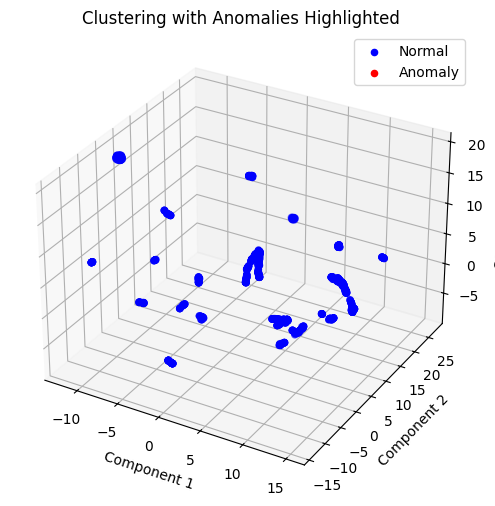

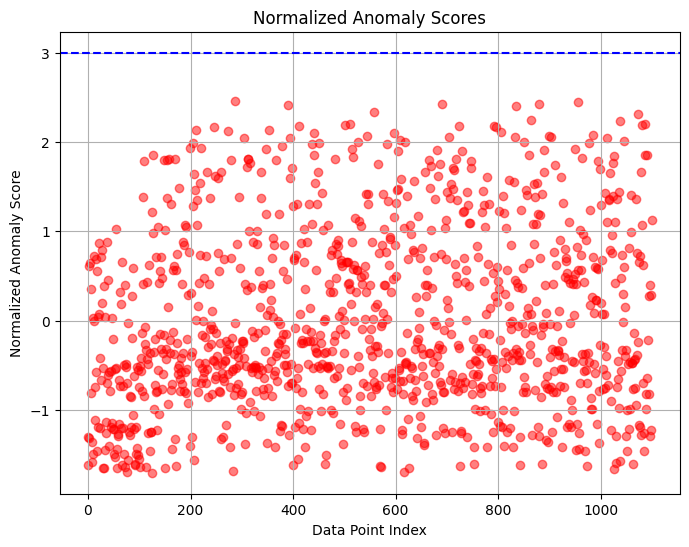

In [38]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

#### Isolation Forest on single observations (normal vs silent)

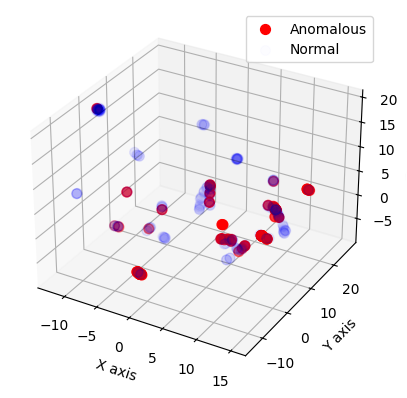

In [43]:
new_data = new_data_silent
labels = labels_silent

# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data[labels == 1][:, 0], new_data[labels == 1][:, 1], new_data[labels == 1][:, 2], 
           color='r', label='Anomalous', s=50)  # Red for anomalies

ax.scatter(new_data[labels == 0][:, 0], new_data[labels == 0][:, 1], new_data[labels == 0][:, 2], 
           color='b', label='Normal', s=50, alpha=0.01)  # Blue for normal points

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

In [44]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,0])
anomaly_scores = d.isolation_forest()

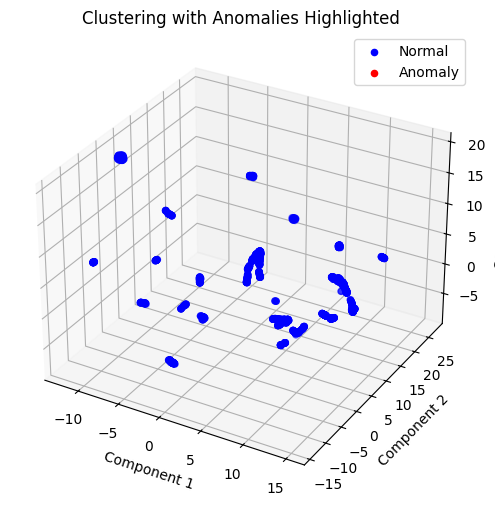

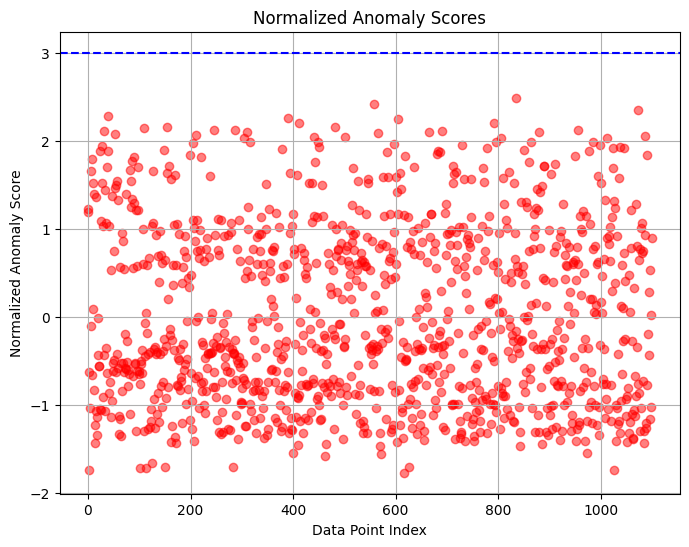

In [45]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

#### Isolation Forest on 3 observations (Normal vs Anomalous)

In [46]:
# reduce with previous umap the anomalous data points
merged_umap_anomalous = r.test_umap(merged_anomalous_reduced)
merged_umap_silent = r.test_umap(merged_silent_reduced)

In [47]:
# creation of artificial anomaly data point
labels = np.concatenate([np.ones(merged_umap_anomalous.shape[0]), np.zeros(merged_umap_reduced_data.shape[0])])
new_data = np.vstack((merged_umap_anomalous, merged_umap_reduced_data))

labels_silent = np.concatenate([np.ones(merged_umap_silent.shape[0]), np.zeros(merged_umap_reduced_data.shape[0])])
new_data_silent = np.vstack((merged_umap_silent, merged_umap_reduced_data))

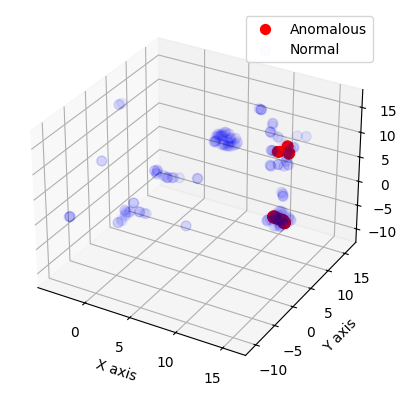

In [48]:
# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data[labels == 1][:, 0], new_data[labels == 1][:, 1], new_data[labels == 1][:, 2],
           c='r', label='Anomalous', s=50)  # Red for anomalies

ax.scatter(new_data[labels == 0][:, 0], new_data[labels == 0][:, 1], new_data[labels == 0][:, 2], 
           c='b', label='Normal', s=50, alpha=0.01)  # Blue for normal points

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()


In [49]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,0])
anomaly_scores = d.isolation_forest()

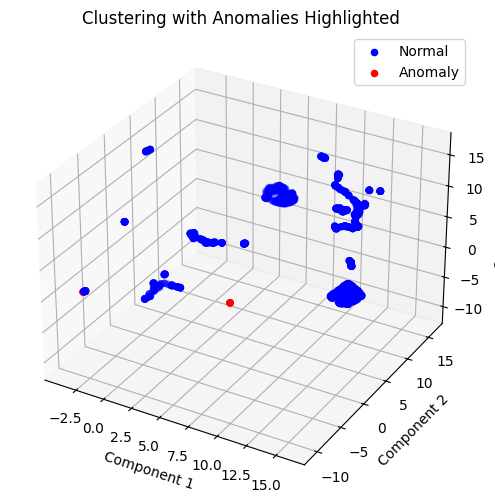

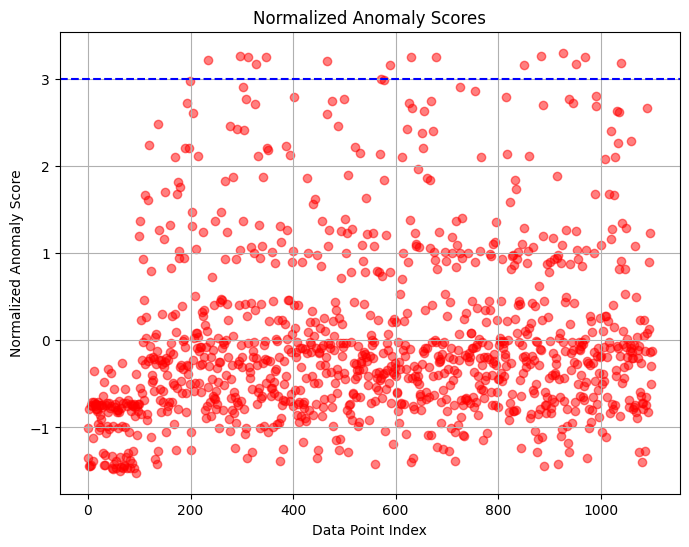

In [50]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

#### Isolation Forest on 3 observations (Normal vs Silent)

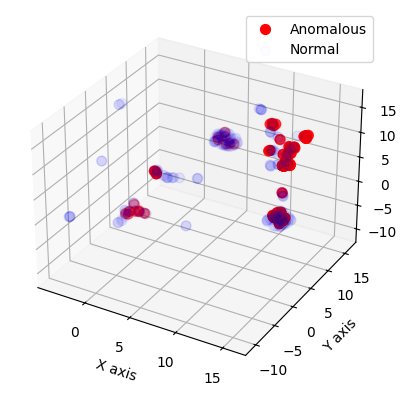

In [51]:
new_data = new_data_silent
labels = labels_silent

# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data[labels == 1][:, 0], new_data[labels == 1][:, 1], new_data[labels == 1][:, 2], 
           color='r', label='Anomalous', s=50)  # Red for anomalies

ax.scatter(new_data[labels == 0][:, 0], new_data[labels == 0][:, 1], new_data[labels == 0][:, 2], 
           color='b', label='Normal', s=50, alpha=0.01)  # Blue for normal points

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

In [52]:
d = DetectAnomaly.DetectAnomaly(new_data, plots=[1,0])
anomaly_scores = d.isolation_forest()

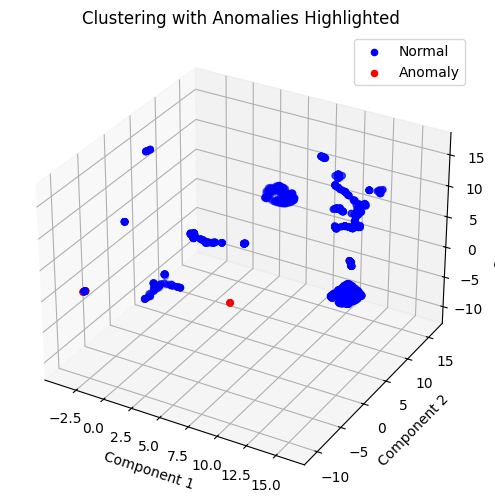

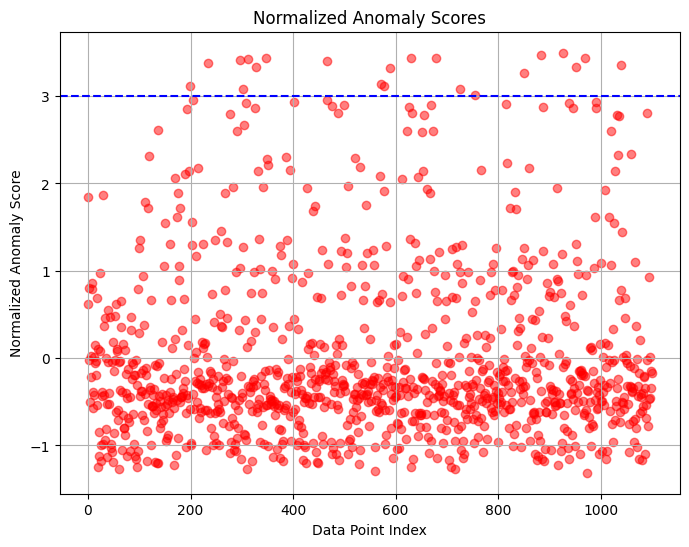

In [53]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

## DL Time Independent

### Normal vs Anomalous (secure)

In [ ]:
# see summary 6 to 9

### Normal vs Anomalous (laurel)

Mean normal reconstruction error: 0.01499112094235114
Mean anomalous reconstruction error: 0.03699694298280672


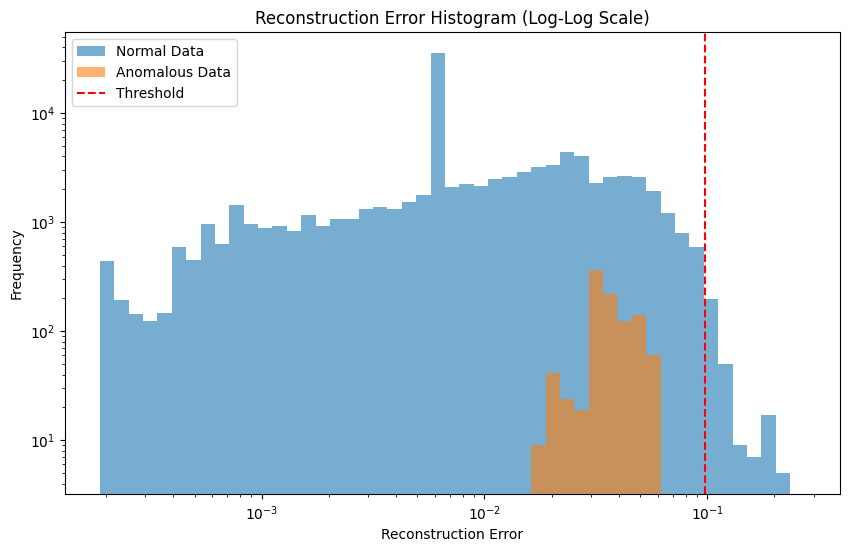

Threshold for anomaly detection: 0.09812170245322219
Number of anomalies detected: 0
Number of false positives detected: 250


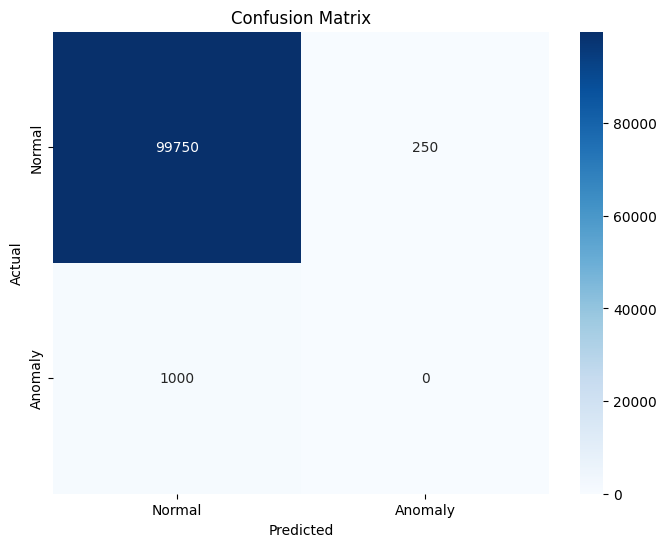

In [38]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_, anomalous_, 'autoencoder', laurel=1, plots=[0,0,1,1])

### Normal vs Anomalous (sequences of 3)

Mean normal reconstruction error: 0.011670057832290973
Mean anomalous reconstruction error: 0.03709298753400388


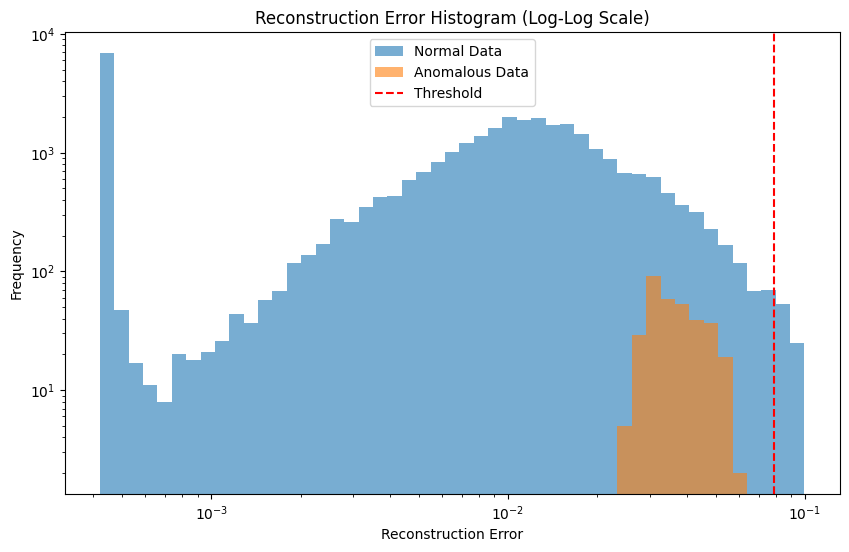

Threshold for anomaly detection: 0.07884219131840499
Number of anomalies detected: 0
Number of false positives detected: 84


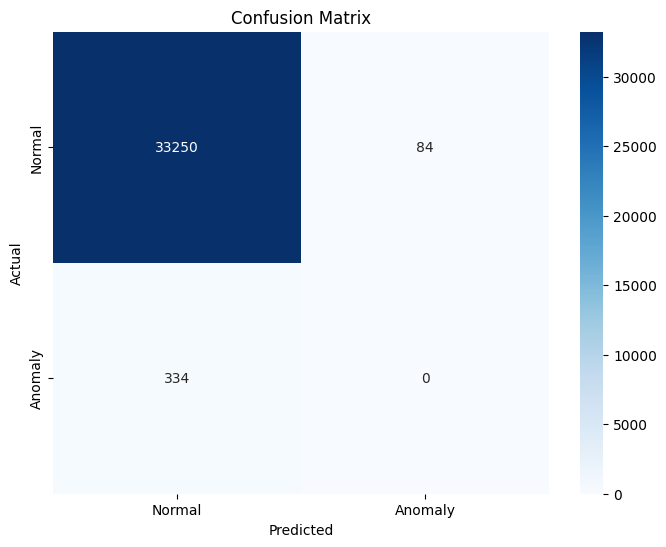

In [64]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(merged_normal, merged_anomalous, 'autoencoder', laurel=1, plots=[0,0,1,1])

### Normal vs Silent (laurel)

Mean normal reconstruction error: 0.0089816216930396
Mean anomalous reconstruction error: 227551.41421392027


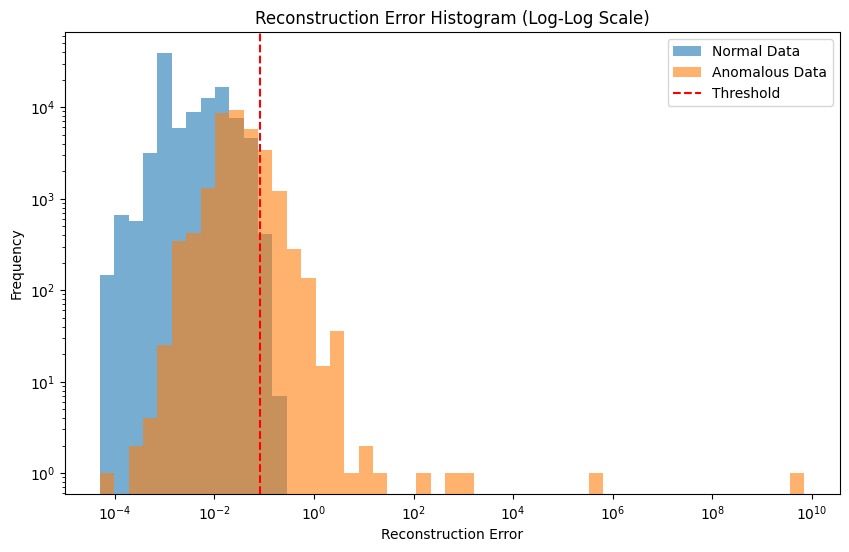

Threshold for anomaly detection: 0.08397678434146842
Number of anomalies detected: 4836
Number of false positives detected: 250


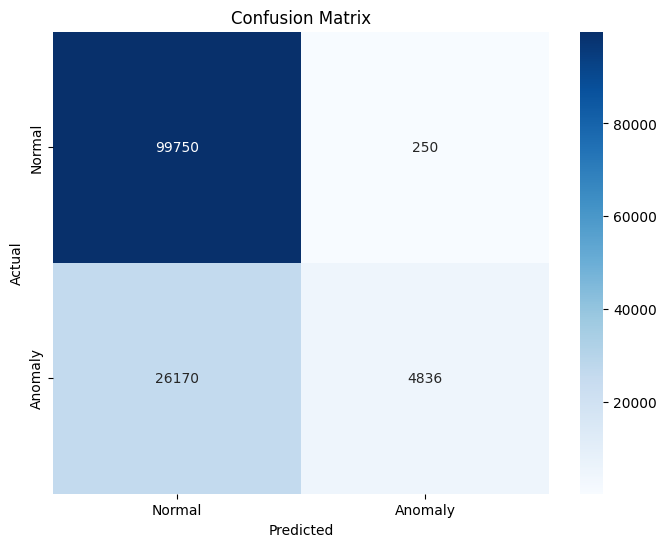

In [39]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_, silent_, 'autoencoder', laurel=1, plots=[0,0,1,1])

In [40]:
# remove features
normal_small = normal_.drop(['pid', 'ppid'], axis=1)
silent_small = silent_.drop(['pid', 'ppid'], axis=1)

Mean normal reconstruction error: 0.00022698968015582593
Mean anomalous reconstruction error: 292564.23281843215


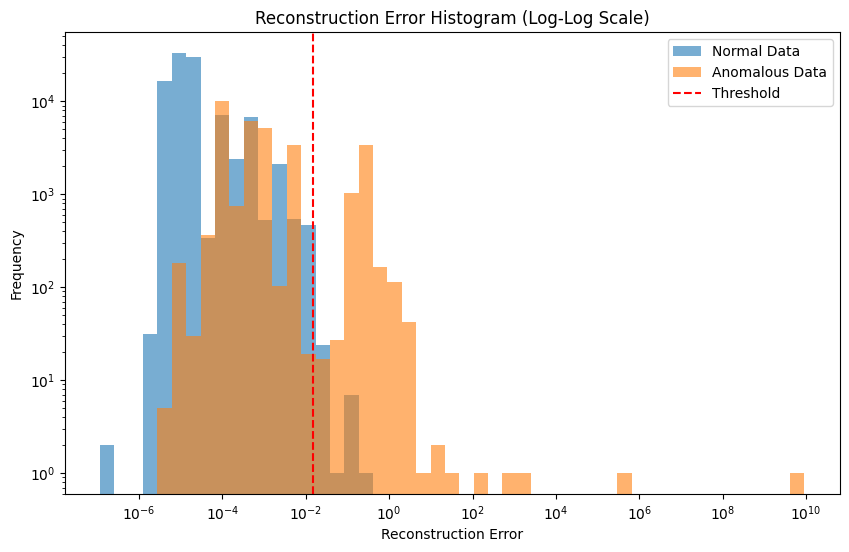

Threshold for anomaly detection: 0.014646855427975464
Number of anomalies detected: 4802
Number of false positives detected: 59


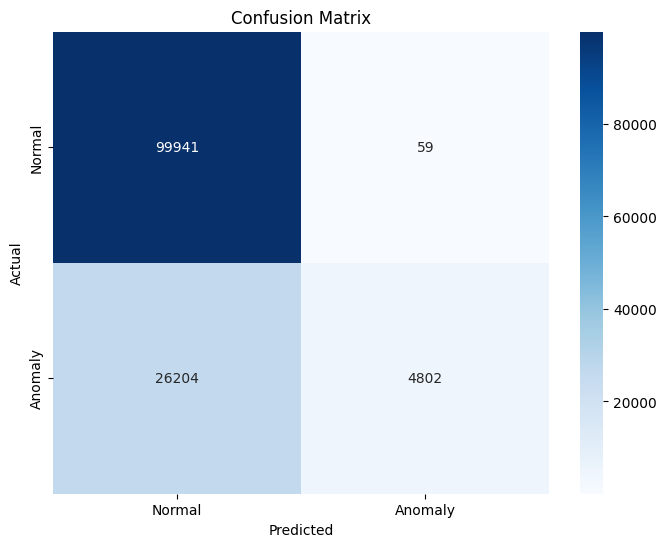

In [41]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_small, silent_small, 'autoencoder', laurel=1, plots=[0,0,1,1])

### Normal vs Silent (Sequences of 3)

Mean normal reconstruction error: 0.01578643420840785
Mean anomalous reconstruction error: 227621.2485622029


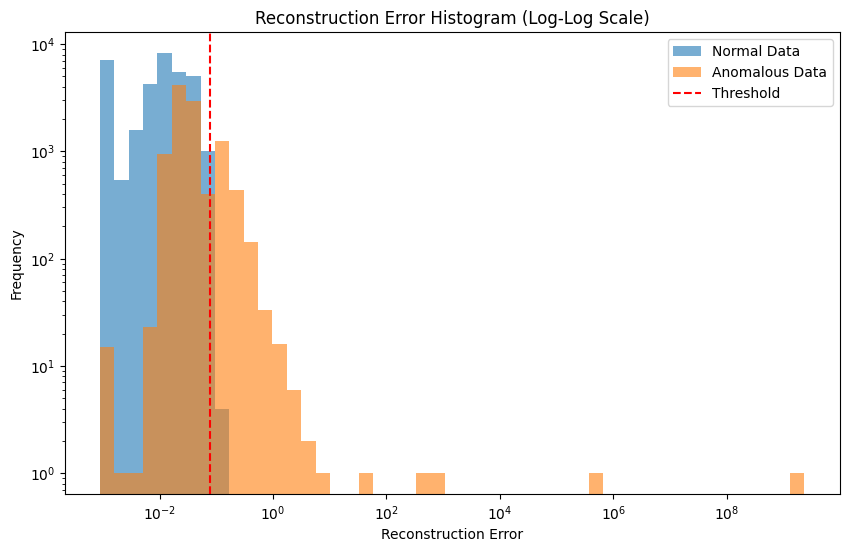

Threshold for anomaly detection: 0.07741846949073236
Number of anomalies detected: 1934
Number of false positives detected: 84


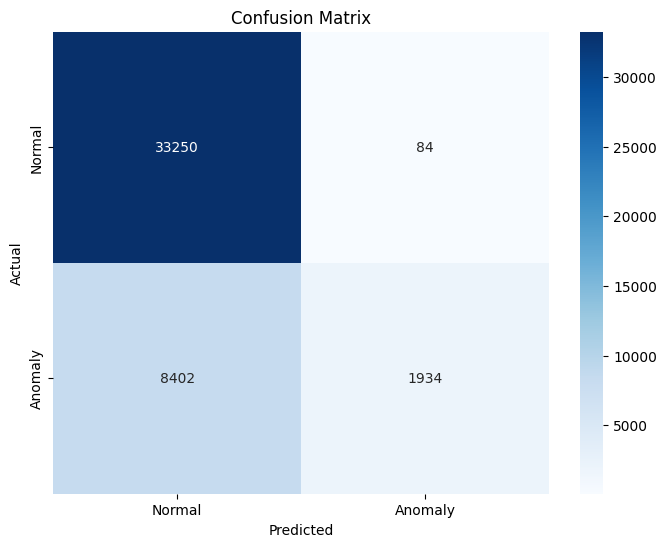

In [65]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(merged_normal, merged_silent, 'autoencoder', laurel=1, plots=[0,0,1,1])

## DL Time Dependent

### MLP

Train shape: (80000, 9)
Test shape: (20000, 9)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 450)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       115,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │         3,483 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 9)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,835 (593.11 KB)

 Trainable params: 151,835 (593.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0453 - mae: 0.1359 - val_loss: 0.0152 - val_mae: 0.0722
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 - mae: 0.0889 - val_loss: 0.0145 - val_mae: 0.0661
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 - mae: 0.0833 - val_loss: 0.0138 - val_mae: 0.0605
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0222 - mae: 0.0798 - val_loss: 0.0136 - val_mae: 0.0588
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0215 - mae: 0.0771 - val_loss: 0.0135 - val_mae: 0.0580
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0209 - mae: 0.0750 - val_loss: 0.0134 - val_mae: 0.0551
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0203 - mae: 0.0734 - val_loss: 0.0132 - val_mae: 0.0547
Epoch 8/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0198 - mae: 0.0720 - val_loss: 0.0132 - val_mae: 0.0545
Epoch 9/2000
200/200 ━━━━━━━━━━━━━━━━━━━

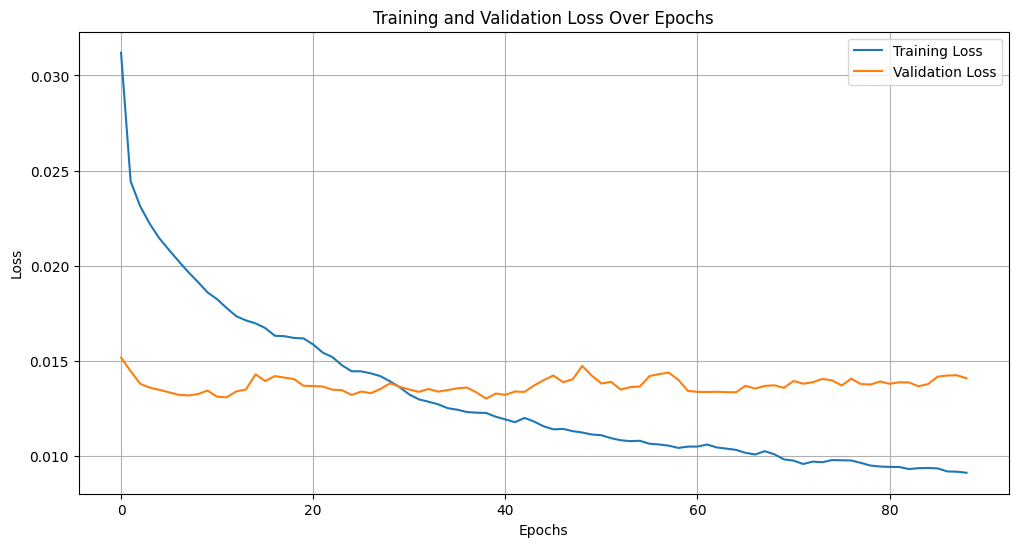

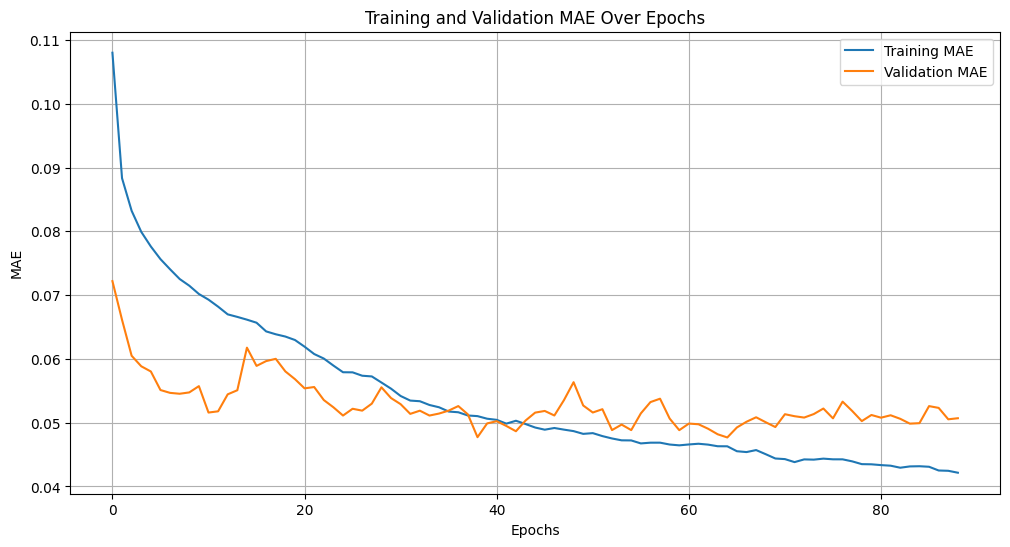

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0195 - mae: 0.0591
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test Loss: 0.025561420246958733
Test MAE: 0.07055416703224182


In [17]:
# to complete
t = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
test_loss, test_mae = t.detect_anomalies(normal_, verbose=1)

In [18]:
print(test_loss, test_mae)

0.025561420246958733 0.07055416703224182


In [20]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
anomalous_max = anomalous_.max()
anomalous_min = anomalous_.min()

anomalous_ = (anomalous_ - anomalous_min) / (anomalous_max - anomalous_min)

X_anomalous, y_anomalous = t2.build_sequences(anomalous_)

X_anomalous = np.nan_to_num(X_anomalous, nan=0.0)
y_anomalous = np.nan_to_num(y_anomalous, nan=0.0)

print(X_anomalous.shape, y_anomalous.shape)

y_pred, test_loss, test_mae = t.predict(X_anomalous, y_anomalous)

(95, 50, 9) (95, 3, 9)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1179 - mae: 0.2527 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [21]:
print(test_loss, test_mae)

0.11725698411464691 0.25195029377937317


In [22]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
silent_max = silent_.max()
silent_min = silent_.min()

silent_ = (silent_ - silent_min) / (silent_max - silent_min)

X_silent, y_silent = t2.build_sequences(silent_)

X_silent = np.nan_to_num(X_silent, nan=0.0)
y_silent = np.nan_to_num(y_silent, nan=0.0)

print(X_silent.shape, y_silent.shape)

y_pred, test_loss, test_mae = t.predict(X_silent, y_silent)

(3100, 50, 9) (3100, 3, 9)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.0877 - mae: 0.1979
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step


In [23]:
print(test_loss, test_mae)

0.08544139564037323 0.19454632699489594


### LSTM

Train shape: (80000, 9)
Test shape: (20000, 9)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 9)          │           585 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 3, 9)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,649 (471.29 KB)

 Trainable params: 120,649 (471.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0401 - mae: 0.1150 - val_loss: 0.0146 - val_mae: 0.0605
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0252 - mae: 0.0817 - val_loss: 0.0142 - val_mae: 0.0597
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0248 - mae: 0.0807 - val_loss: 0.0141 - val_mae: 0.0589
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0244 - mae: 0.0794 - val_loss: 0.0140 - val_mae: 0.0570
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0241 - mae: 0.0778 - val_loss: 0.0139 - val_mae: 0.0560
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0238 - mae: 0.0764 - val_loss: 0.0138 - val_mae: 0.0549
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0232 - mae: 0.0749 - val_loss: 0.0137 - val_mae: 0.0537
Epoch 8/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0229 - mae: 0.0739 - val_loss: 0.0138 - val_mae: 0.0552
Epoch 9/2000
200/200 ━━━━━━━━━

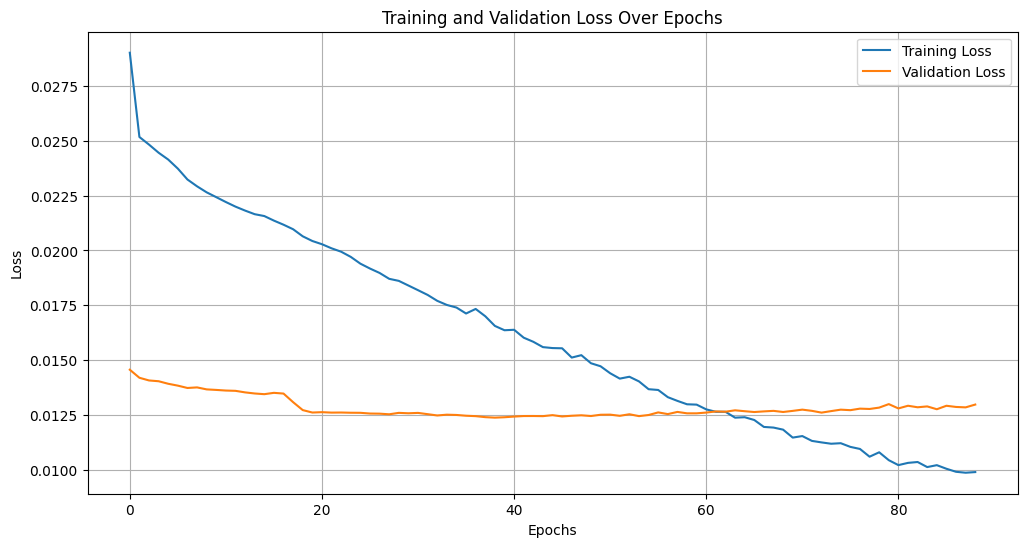

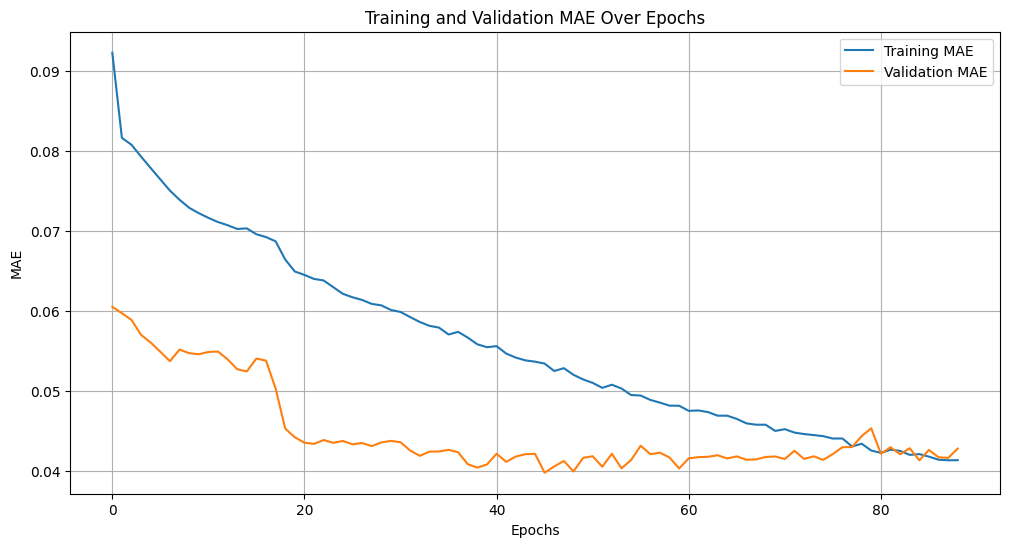

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0159 - mae: 0.0506
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Test Loss: 0.019842712208628654
Test MAE: 0.06127087026834488


In [24]:
test_loss, test_mae = t.detect_anomalies_LSTM(normal_, verbose=1)

In [ ]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
anomalous_max = anomalous_.max()
anomalous_min = anomalous_.min()

anomalous_ = (anomalous_ - anomalous_min) / (anomalous_max - anomalous_min)

X_anomalous, y_anomalous = t2.build_sequences(anomalous_)

X_anomalous = np.nan_to_num(X_anomalous, nan=0.0)
y_anomalous = np.nan_to_num(y_anomalous, nan=0.0)

print(X_anomalous.shape, y_anomalous.shape)

y_pred, test_loss, test_mae = t.predict(X_anomalous, y_anomalous)

In [ ]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
silent_max = silent_.max()
silent_min = silent_.min()

silent_ = (silent_ - silent_min) / (silent_max - silent_min)

X_silent, y_silent = t2.build_sequences(silent_)

X_silent = np.nan_to_num(X_silent, nan=0.0)
y_silent = np.nan_to_num(y_silent, nan=0.0)

print(X_silent.shape, y_silent.shape)

y_pred, test_loss, test_mae = t.predict(X_silent, y_silent)

### Transformer

Train shape: (80000, 9)
Test shape: (20000, 9)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 9)     │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 9)     │      1,413 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 9)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 50, 9)     │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 9)     │         18 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 128)   │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 9)     │      1,161 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 50, 9)     │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 50, 9)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 9)     │         18 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 9)     │      1,413 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 50, 9)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 50, 9)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 9)     │         18 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 50, 128)   │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 50, 9)     │      1,161 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 9)     │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 50, 9)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 9)     │         18 │ add_4[0][0]     

 Total params: 7,870 (30.74 KB)

 Trainable params: 7,870 (30.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.3200 - mae: 0.3792 - val_loss: 0.0317 - val_mae: 0.1380
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0451 - mae: 0.1540 - val_loss: 0.0177 - val_mae: 0.0841
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0322 - mae: 0.1150 - val_loss: 0.0138 - val_mae: 0.0595
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0291 - mae: 0.1025 - val_loss: 0.0136 - val_mae: 0.0569
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0281 - mae: 0.0989 - val_loss: 0.0136 - val_mae: 0.0550
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0273 - mae: 0.0959 - val_loss: 0.0135 - val_mae: 0.0565
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0270 - mae: 0.0940 - val_loss: 0.0135 - val_mae: 0.0551
Epoch 8/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0264 - mae: 0.0914 - val_loss: 0.0134 - val_mae: 0.0547
Epoch 9/2000
200/200 ━━━━━━━━━━━

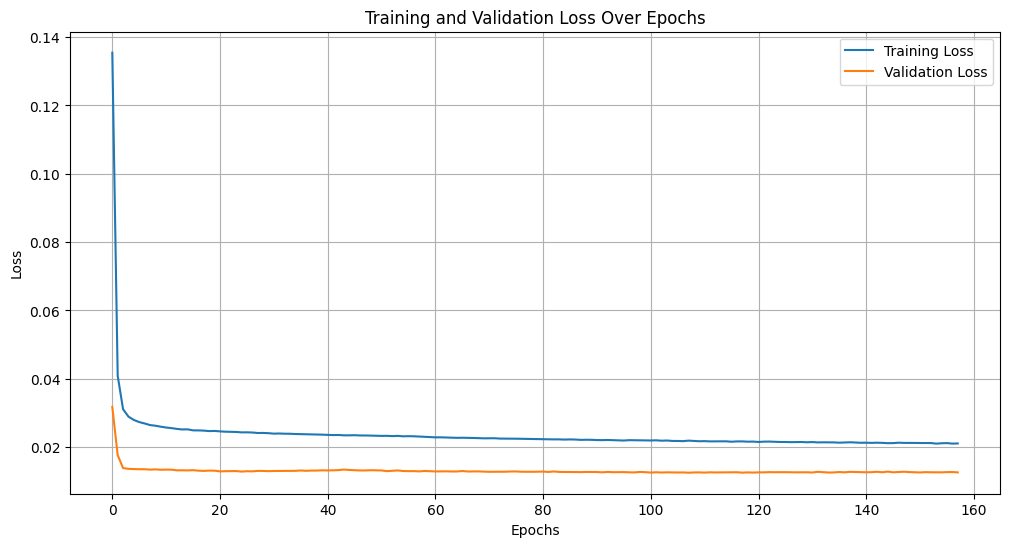

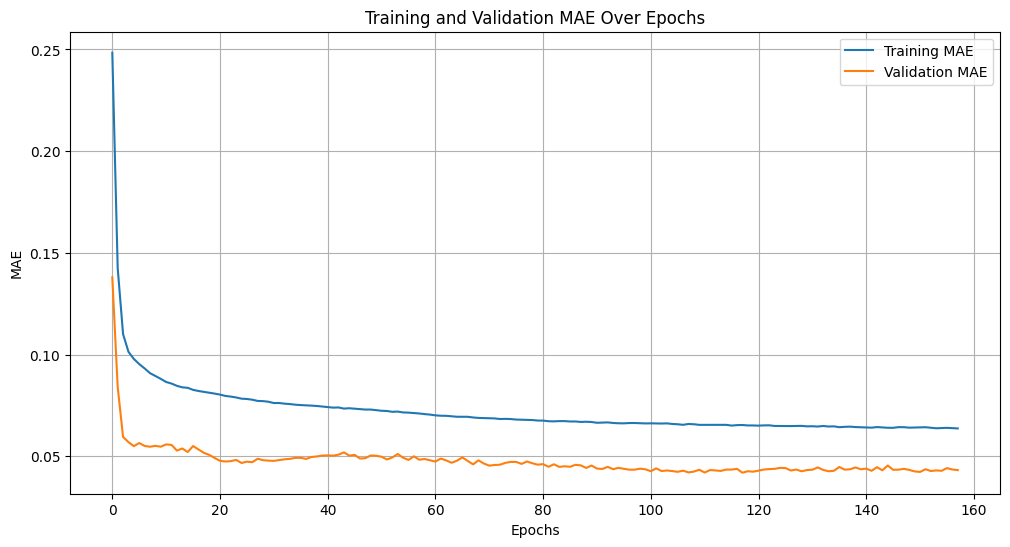

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181 - mae: 0.0573
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Test Loss: 0.02354746125638485
Test MAE: 0.07166775315999985


In [25]:
test_loss, test_mae = t.detect_anomalies_transformer(normal_, verbose=1)

In [26]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
anomalous_max = anomalous_.max()
anomalous_min = anomalous_.min()

anomalous_ = (anomalous_ - anomalous_min) / (anomalous_max - anomalous_min)

X_anomalous, y_anomalous = t2.build_sequences(anomalous_)

X_anomalous = np.nan_to_num(X_anomalous, nan=0.0)
y_anomalous = np.nan_to_num(y_anomalous, nan=0.0)

print(X_anomalous.shape, y_anomalous.shape)

y_pred_anomalous, test_loss_anomalous, test_mae_anomalous = t.predict(X_anomalous, y_anomalous)

(95, 50, 9) (95, 3, 9)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1172 - mae: 0.2346 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [27]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
silent_max = silent_.max()
silent_min = silent_.min()

silent_ = (silent_ - silent_min) / (silent_max - silent_min)

X_silent, y_silent = t2.build_sequences(silent_)

X_silent = np.nan_to_num(X_silent, nan=0.0)
y_silent = np.nan_to_num(y_silent, nan=0.0)

print(X_silent.shape, y_silent.shape)

y_pred_silent, test_loss_silent, test_mae_silent = t.predict(X_silent, y_silent)

(3100, 50, 9) (3100, 3, 9)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1070 - mae: 0.2311
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


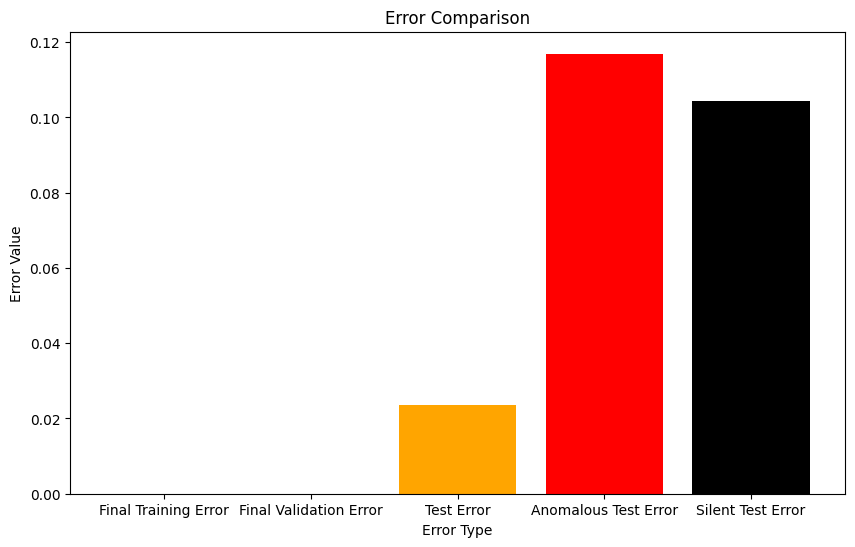

In [29]:
# Example error values (replace these with your actual error values)
final_training_error = 0#history.history['loss'][-1]
final_validation_error = 0#history.history['val_loss'][-1]
test_error = test_loss
anomalous_test_error = test_loss_anomalous
silent_test_error = test_loss_silent

# Labels and values
labels = ['Final Training Error', 'Final Validation Error', 'Test Error', 'Anomalous Test Error', 'Silent Test Error']
values = [final_training_error, final_validation_error, test_error, anomalous_test_error, silent_test_error]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange', 'red', 'black'])

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Error Value')
plt.title('Error Comparison')

# Show the plot
plt.show()